In [1]:
from Parameters import ModelParams
from Mass_Loss_Class import MassLoss
from Fractionation_Class import Fractionation
from Flow_Solutions_Class import FlowSolutions
from Model_Data_Loader import ModelDataLoader
from Results_Handler import ResultsHandler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Mass-loss results: [{'REUV': 508221374.9311671, 'cs': 156554.14735922212, 'Mdot': np.float64(139622794.96048734)}, {'REUV': 582666651.8754727, 'cs': 194313.77815119646, 'Mdot': np.float64(105207912.07725066)}, {'REUV': 685295420.6857324, 'cs': 241530.03885177447, 'Mdot': np.float64(85608318.73275653)}, {'REUV': 814710437.024746, 'cs': 300904.0914599063, 'Mdot': np.float64(71924550.40667625)}, {'REUV': 901789811.2901604, 'cs': 342873.78390623466, 'Mdot': np.float64(65004084.556887835)}, {'REUV': 968143124.8026733, 'cs': 376535.32056149543, 'Mdot': np.float64(60328036.22109525)}, {'REUV': 1021971449.0961115, 'cs': 405211.49003210216, 'Mdot': np.float64(56767843.210147515)}, {'REUV': 1067427289.3090506, 'cs': 430476.67756289296, 'Mdot': np.float64(53901131.10825828)}, {'REUV': 1106884354.4753172, 'cs': 453185.18360655825, 'Mdot': np.float64(51523463.9008275)}, {'REUV': 1142116146.143941, 'cs': 473953.0528894289, 'Mdot': np.float64(49518778.53762398)}, {'REUV': 1173009217.3330886, 'cs': 49

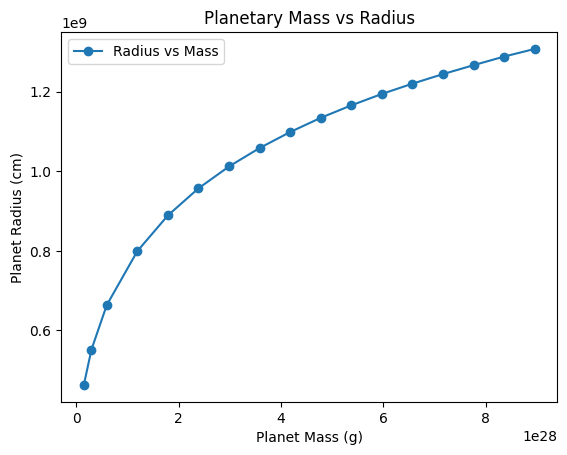

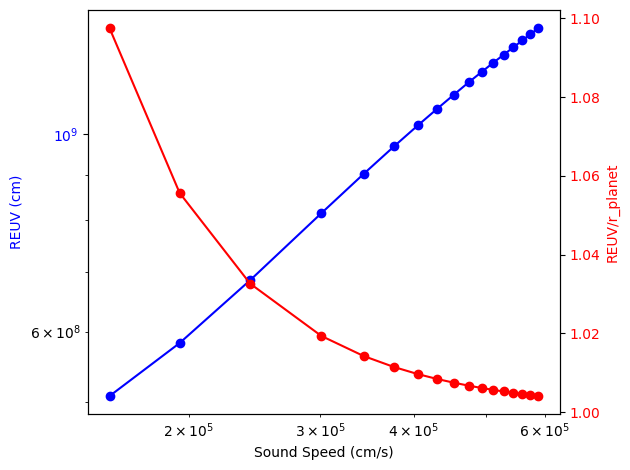

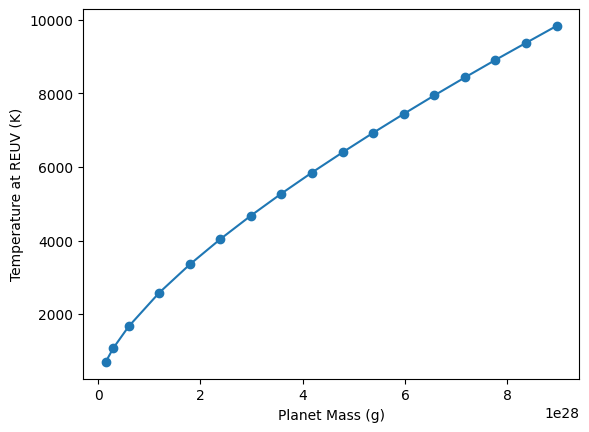

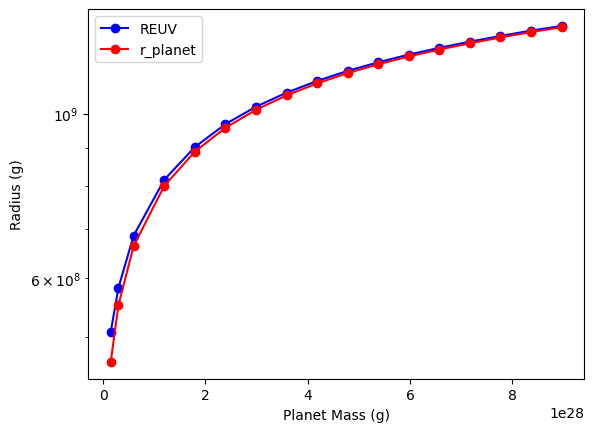

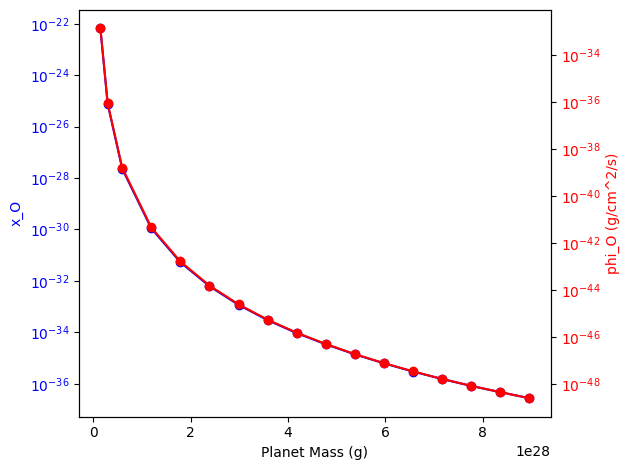

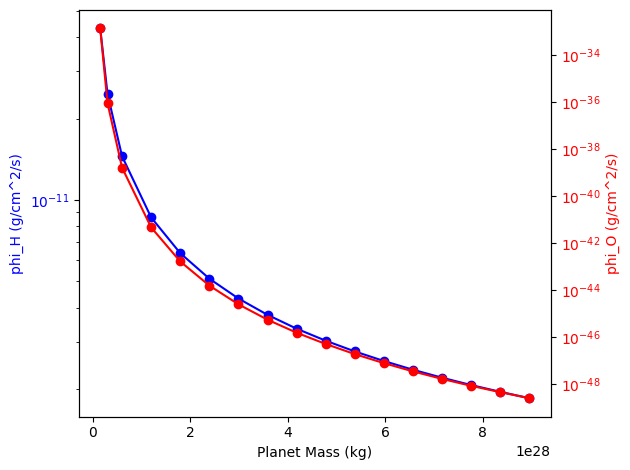

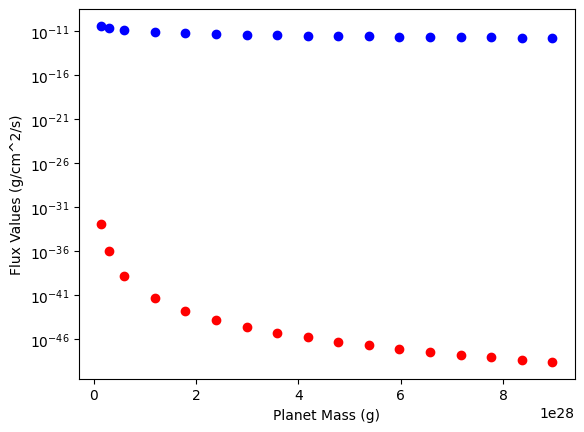

In [3]:
def main():

    # initialize parameters and classes
    params = ModelParams()
    base_path = '/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/CW/critical_WMF/gridmin295/'
    data_loader = ModelDataLoader(base_path)
    mass_loss = MassLoss(params)
    fractionation = Fractionation(params)

    # load data
    m_planet = [0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    water_percent = [x / 10 for x in range(1, 81)]
    radii_list, mass_list, teq_list = data_loader.load_model_data(m_planet, water_percent)

    # mass loss model
    results = mass_loss.compute_mass_loss_parameters(mass_list, radii_list, teq_list)
    relevant_results = [{'REUV': res['REUV'], 'cs': res['cs'], 'Mdot': res['Mdot']} for res in results]
    print("Mass-loss results:", relevant_results)

    # fractionation model
    all_results = []
    for planet_index, result in enumerate(results):
        cs = result['cs']
        REUV = result['REUV']
        Mdot = result['Mdot']
        m_planet = result['mass']
        r_planet = result['radius']

        T_REUV, b_i, mass_difference, flux_total, reservoir_ratio = fractionation.preprocess_fractionation_params(cs, REUV, Mdot)

        phi_O, phi_H, x_O = fractionation.iterative_fractionation(flux_total, REUV, m_planet, T_REUV, b_i, mass_difference, reservoir_ratio)
        print(f"Planet {planet_index} Fractionation Results: phi_O = {phi_O}, phi_H = {phi_H}, x_O = {x_O}")

        planet_results = {'m_planet': m_planet, 'r_planet': r_planet, 'REUV': REUV, 'cs': cs, 'Mdot': Mdot, 'T_REUV': T_REUV, 'phi_H': phi_H, 'phi_O': phi_O, 'x_O': x_O, 'REUV': REUV, 'cs': cs, 'Mdot': Mdot}
        all_results.append(planet_results)

    # save and/or plot results
    # ResultsHandler.save_results(all_results, "fractionation_results.pkl")
    ResultsHandler.plot_m_planet_r_planet(all_results)
    ResultsHandler.plot_cs_REUV(all_results)
    ResultsHandler.plot_T_REUV_m_planet(all_results)
    ResultsHandler.plot_REUV_r_planet_vs_m_planet(all_results)
    ResultsHandler.plot_xO_phiO_vs_m_planet(all_results)
    ResultsHandler.plot_phiH_phiO_vs_m_planet(all_results)
    ResultsHandler.plot_phiH_phiO_vs_m_planet_color(all_results)

if __name__ == "__main__":
   main()